# Medical Image Analysis

### Install the necessary packages

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 3.0MB 45.0MB/s 
     |████████████████████████████████| 460kB 56.5MB/s 
     |████████████████████████████████| 2.9MB 42.4MB/s 
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


### Downloading the dataset

In [3]:
!mkdir malaria
%cd malaria
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!unzip -qq cell_images.zip
%cd ..

/content/dl-medical-imaging/malaria
--2021-06-07 18:24:53--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   109MB/s    in 3.1s    

2021-06-07 18:24:56 (109 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

/content/dl-medical-imaging


### Import Packages

In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from pyimagesearch.resnet import ResNet
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import shutil
import os

### Our configuration file

In [5]:
class Config:
    # initialize the path to the *original* input directory of images
    ORIG_INPUT_DATASET = "malaria/cell_images"

    # initialize the base path to the *new* directory that will contain
    # our images after computing the training and testing split
    BASE_PATH = "malaria"

    # derive the training, validation, and testing directories
    TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
    VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
    TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

    # define the amount of data that will be used training
    TRAIN_SPLIT = 0.8

    # the amount of validation data will be a percentage of the
    # *training* data
    VAL_SPLIT = 0.1

# instantiate a config object
config = Config()

### Building our deep learning + medical image dataset

In [6]:
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [7]:
# compute the training and testing split
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# we'll be using part of the training data for validation
i = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

In [8]:
# define the datasets that we'll be building
datasets = [
	("training", trainPaths, config.TRAIN_PATH),
	("validation", valPaths, config.VAL_PATH),
	("testing", testPaths, config.TEST_PATH)
]

In [9]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))

	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)

	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]

		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)

		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating malaria/training' directory
[INFO] 'creating malaria/training/Uninfected' directory
[INFO] 'creating malaria/training/Parasitized' directory
[INFO] building 'validation' split
[INFO] 'creating malaria/validation' directory
[INFO] 'creating malaria/validation/Uninfected' directory
[INFO] 'creating malaria/validation/Parasitized' directory
[INFO] building 'testing' split
[INFO] 'creating malaria/testing' directory
[INFO] 'creating malaria/testing/Uninfected' directory
[INFO] 'creating malaria/testing/Parasitized' directory


### Training a deep learning model for medical image analysis

In [10]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "plot": "plot.png"
}

In [11]:
# define the total number of epochs to train for along with the
# initial learning rate and batch size
NUM_EPOCHS = 50
INIT_LR = 1e-1
BS = 32

def poly_decay(epoch):
	# initialize the maximum number of epochs, base learning rate,
	# and power of the polynomial
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0

	# compute the new learning rate based on polynomial decay
	alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

	# return the new learning rate
	return alpha

In [12]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))

In [13]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [14]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	config.TRAIN_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	config.VAL_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	config.TEST_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [15]:
# initialize our ResNet model and compile it
model = ResNet.build(64, 64, 3, 2, (3, 4, 6),
	(64, 128, 256, 512), reg=0.0005)
opt = SGD(lr=INIT_LR, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [16]:
# define our set of callbacks and fit the model
callbacks = [LearningRateScheduler(poly_decay)]
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS,
	callbacks=callbacks)

Epoch 1/50
620/620 [==============================] - 49s 79ms/step - loss: 1.1085 - accuracy: 0.7166 - val_loss: 0.7826 - val_accuracy: 0.8810 - lr: 0.1000
Epoch 2/50
620/620 [==============================] - 48s 77ms/step - loss: 0.5937 - accuracy: 0.9503 - val_loss: 0.5334 - val_accuracy: 0.9517 - lr: 0.0980
Epoch 3/50
620/620 [==============================] - 48s 77ms/step - loss: 0.5443 - accuracy: 0.9431 - val_loss: 0.4708 - val_accuracy: 0.9545 - lr: 0.0960
Epoch 4/50
620/620 [==============================] - 48s 77ms/step - loss: 0.4290 - accuracy: 0.9524 - val_loss: 0.3930 - val_accuracy: 0.9545 - lr: 0.0940
Epoch 5/50
620/620 [==============================] - 48s 77ms/step - loss: 0.3630 - accuracy: 0.9539 - val_loss: 0.3449 - val_accuracy: 0.9545 - lr: 0.0920
Epoch 6/50
620/620 [==============================] - 48s 77ms/step - loss: 0.3164 - accuracy: 0.9565 - val_loss: 0.3300 - val_accuracy: 0.9527 - lr: 0.0900
Epoch 7/50
620/620 [==============================] - 47s 

In [17]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // BS) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

[INFO] evaluating network...
              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      2786
  Uninfected       0.96      0.98      0.97      2726

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



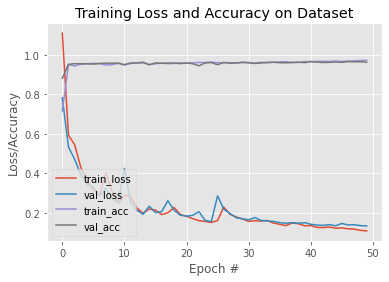

In [18]:
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()